# Transformer: LoRA fine-tuned DistilBERT
LoRA rank 16, alpha 32, dropout 0.1 on q_lin and v_lin. 10 epochs, lr 2e-4, batch 4 with gradient accumulation 4.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
sns.set_style('whitegrid')

c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Data
1508 rows, 6 topics, binary labels.

In [2]:
source_path = '../../data_analysis/data.parquet'
df_raw = pd.read_parquet(source_path)

features_expanded = pd.json_normalize(df_raw['feature_cache'])
df = pd.concat([df_raw[['id', 'class', 'topic', 'text']].reset_index(drop=True),
                features_expanded[['author']].reset_index(drop=True)], axis=1)

df['label'] = (df['class'] > 1).astype(int)
print(f'Loaded {len(df)} rows')
print(f'Class distribution: {df["label"].value_counts().to_dict()}')

Loaded 1508 rows
Class distribution: {1: 1008, 0: 500}


In [3]:
df['strat_key'] = df['class'].astype(str) + '_' + df['author'].astype(str)

train_val, test = train_test_split(df, test_size=0.15, stratify=df['strat_key'], random_state=42)
train, val = train_test_split(train_val, test_size=0.15/0.85, stratify=train_val['strat_key'], random_state=42)

print(f'Train: {len(train)}, Val: {len(val)}, Test: {len(test)}')

train[['id', 'class', 'topic', 'author']].to_parquet('train.parquet', index=False)
val[['id', 'class', 'topic', 'author']].to_parquet('validate.parquet', index=False)
test[['id', 'class', 'topic', 'author']].to_parquet('test.parquet', index=False)

Train: 1054, Val: 227, Test: 227


## Model setup
DistilBERT-base-uncased with LoRA adapters.

In [4]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

base_model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type='single_label_classification'
).to(device)
print(f'Loaded {model_name} on {device}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded distilbert-base-uncased on cuda


In [5]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['q_lin', 'v_lin']
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

trainable params: 887,042 || all params: 67,842,052 || trainable%: 1.3075


## Training prep

In [6]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextDataset(train['text'], train['label'], tokenizer)
val_dataset = TextDataset(val['text'], val['label'], tokenizer)
test_dataset = TextDataset(test['text'], test['label'], tokenizer)

print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')

Train samples: 1054, Val samples: 227


In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs[:, 1])
    return {'accuracy': acc, 'auc': auc}

In [8]:
training_args = TrainingArguments(
    output_dir='./transformer_checkpoints',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    weight_decay=0.01,
    learning_rate=2e-4,
    logging_dir='./logs',
    logging_steps=25,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='auc',
    greater_is_better=True,
    report_to='none',
    fp16=True,
    dataloader_num_workers=0,
    optim='adamw_torch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

## Training

In [9]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.423000,0.281477,0.850220,0.989543
2,0.098000,0.049229,0.986784,0.997734
3,0.037400,0.062635,0.969163,0.998432
4,0.038600,0.046681,0.973568,0.998954
5,0.022500,0.043513,0.977974,0.998780
6,0.008600,0.056762,0.973568,0.998693
7,0.002000,0.043813,0.986784,0.999041
8,0.000500,0.067028,0.973568,0.998780
9,0.001500,0.062938,0.973568,0.998867
10,0.000600,0.059592,0.977974,0.998780


TrainOutput(global_step=660, training_loss=0.07118461945969047, metrics={'train_runtime': 1482.8999, 'train_samples_per_second': 7.108, 'train_steps_per_second': 0.445, 'total_flos': 712463904153600.0, 'train_loss': 0.07118461945969047, 'epoch': 10.0})

## Evaluation

In [10]:
val_predictions = trainer.predict(val_dataset)
val_probs = torch.softmax(torch.tensor(val_predictions.predictions), dim=1).numpy()[:, 1]
val_preds = np.argmax(val_predictions.predictions, axis=1)

val_results = val.copy().reset_index(drop=True)
val_results['prob_ai'] = val_probs
val_results['pred'] = val_preds
val_results['actual_binary'] = val_results['label']

auc = roc_auc_score(val_results['actual_binary'], val_results['prob_ai'])
acc = accuracy_score(val_results['actual_binary'], val_results['pred'])
print(f'Validation AUC: {auc:.4f}')
print(f'Validation Accuracy: {acc:.4f}')

Validation AUC: 0.9990
Validation Accuracy: 0.9868


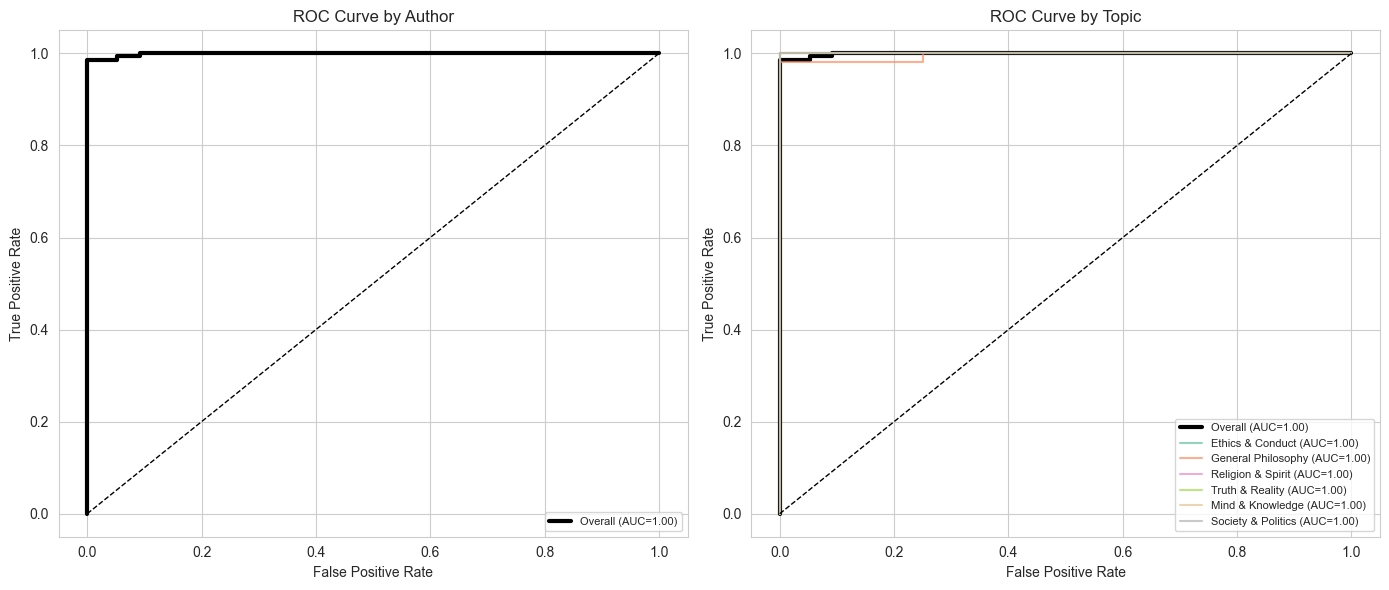

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fpr, tpr, _ = roc_curve(val_results['actual_binary'], val_results['prob_ai'])

ax1 = axes[0]
ax1.plot(fpr, tpr, 'k-', lw=3, label=f'Overall (AUC={auc:.2f})')

colors = plt.cm.tab10(np.linspace(0, 1, len(val_results['author'].unique())))
for i, author in enumerate(val_results['author'].unique()):
    mask = val_results['author'] == author
    if mask.sum() > 5:
        y_true_sub = val_results[mask]['actual_binary']
        y_prob_sub = val_results[mask]['prob_ai']
        if len(y_true_sub.unique()) > 1:
            fpr_sub, tpr_sub, _ = roc_curve(y_true_sub, y_prob_sub)
            auc_sub = roc_auc_score(y_true_sub, y_prob_sub)
            ax1.plot(fpr_sub, tpr_sub, color=colors[i], lw=1.5, alpha=0.7,
                     label=f'{author} (AUC={auc_sub:.2f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve by Author')
ax1.legend(loc='lower right', fontsize=8)

ax2 = axes[1]
ax2.plot(fpr, tpr, 'k-', lw=3, label=f'Overall (AUC={auc:.2f})')

colors_t = plt.cm.Set2(np.linspace(0, 1, len(val_results['topic'].unique())))
for i, topic in enumerate(val_results['topic'].unique()):
    mask = val_results['topic'] == topic
    if mask.sum() > 5:
        y_true_sub = val_results[mask]['actual_binary']
        y_prob_sub = val_results[mask]['prob_ai']
        if len(y_true_sub.unique()) > 1:
            fpr_sub, tpr_sub, _ = roc_curve(y_true_sub, y_prob_sub)
            auc_sub = roc_auc_score(y_true_sub, y_prob_sub)
            ax2.plot(fpr_sub, tpr_sub, color=colors_t[i], lw=1.5, alpha=0.7,
                     label=f'{topic} (AUC={auc_sub:.2f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve by Topic')
ax2.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Test set

In [12]:
test_predictions = trainer.predict(test_dataset)
test_probs = torch.softmax(torch.tensor(test_predictions.predictions), dim=1).numpy()[:, 1]
test_preds = np.argmax(test_predictions.predictions, axis=1)
y_test = test['label'].values
test_auc = roc_auc_score(y_test, test_probs)
test_acc = accuracy_score(y_test, test_preds)
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Test AUC: 0.9992
Test Accuracy: 0.9868
